# Хакатон Моторика

## Часть 2. Задача классификации непрерывных команд от пользователя на основе данных, полученных от оптомиографических датчиков


- Данные представляют из себя временные ряды, где в каждый момент времени фиксируются показания от датчиков.
- Целевая переменная представляет из себя маску команды выполняемого пользователем жеста в каждый момент времени.

Целевая переменная содержит следующие классы: 
- 0 - команда "жест open";
- 1 - команда "сгиб мизинца";
- 2 - команда "сгиб безымянного пальца";
- 3 - команда "сгиб среднего пальца";
- 4 - команда "жест пистолет";
- 5 - команда "сгиб указательного пальца";
- 6 - команда "сгиб большога пальца";
- 7 - команда "жест ОК";
- 8 - команда "жест grab";

Видно, что классов стало меньше, это объясняется тем, что в данной постановке мы работаем не с жестами, а с командами выполняемыми пользователем. Если есть команда "жест grab", значит в этот момент пользователь выполняет схват (аналогично и остальные жесты, кроме "жеста open"). В прошлой задаче каждому жесту сгибу противопоставлялся жест разгиба. В текущей постановке есть "жест open", который обозначает, что пользователь возвращает руку в нейтральное состояние (раскрытая ладонь).


## 1. Исследование данных

#### Загрузка библиотек

In [395]:
import numpy as np
import pandas as pd
# import time
import matplotlib.pyplot as plt 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image



#### Формат и размерность данных

In [396]:
data = np.load('data/X_train.npy')
data.shape

(323, 40, 100)

Количество наблюденний увеличилось, сенсоров осталось 40, отсчетов времени теперь 100.

In [397]:
score_test = np.load('data/X_test.npy')
score_test.shape

(54, 40, 100)

Количество наблюдений на тестовом наборе сократилось, сенсоров осталось 40, отсчетов времени также 100

### Исследование целевой переменной

In [398]:
target = pd.read_csv('data/y_train.csv', index_col=0)
print(target.shape) 
target.tail(10)

(32300, 1)


,class
sample-timestep,
322-90,4
322-91,4
322-92,4
322-93,4
322-94,4
322-95,4
322-96,4
322-97,4
322-98,4


In [399]:
target = target['class'].values
print('Unique values', list(np.unique(target)))
target = target.reshape((323,100))


Unique values [0, 1, 2, 3, 4, 5, 6, 7, 8]


Целевая переменная имеет формат 323 наблюдения длительностью 100 отсчетов, каждое.  Можно просто изменить форму массива с (32300,1) на (323, 100).  В целевой переменной содержатся метки нескольких классов. Метка 0 соответствует отсутствию движения. И еще метки 1..8 для жестов.  

In [400]:
sample_subm = pd.read_csv('data/sample_submission.csv', index_col=0)
print(sample_subm.shape) 
sample_subm.tail(10)

(5400, 1)


,class
sample-timestep,
376-90,5
376-91,4
376-92,7
376-93,1
376-94,1
376-95,3
376-96,1
376-97,0
376-98,5


In [401]:
sample_subm.head()

,class
sample-timestep,
323-0,0
323-1,7
323-2,3
323-3,0
323-4,5


В постановке задачи есть фраза "некоторое решение задачи из которого можно взять формат".  По видимомму речь идет только о формате, а значения меток заполнены случайным образом.

In [402]:
#смотрю начало и конец каждой метки
t_st = target[:,0]
t_fn = target[:,99]
g_list = list()
for i in range(323):
    g_list.append(str(t_st[i])+'-'+str(t_fn[i]))
print('Набор жестов',sorted(set(g_list)))
cntr=dict()
for l in g_list: 
    prev = cntr.get(l,0)
    cntr[l] = prev+1 
print('Распределение наблюдений по жестам',cntr)

Набор жестов ['0-0', '0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '1-0', '2-0', '3-0', '4-0', '5-0', '6-0', '7-0', '8-0']
Распределение наблюдений по жестам {'0-0': 36, '0-6': 18, '6-0': 18, '0-5': 18, '5-0': 18, '0-3': 18, '3-0': 18, '0-2': 18, '2-0': 18, '0-1': 18, '1-0': 18, '0-8': 18, '8-0': 18, '0-7': 18, '7-0': 18, '0-4': 18, '4-0': 17}


Данные представляют собой жесты - переходы из состояния покоя в один жестов, или обратно.  Набор данных не совсем сбалансирован. Жестов в состоянии покоя - 36, остальных по 18.  Интересен момент перехода метки из/в состояние "0".

In [403]:
#   Функция поиска позиции первого или последнего ненулевого элемента
def find_change_poss(data):
    nnz = np.count_nonzero(data)
    if nnz == 0 : return 0
    nzpos = np.flatnonzero(data)
    return nzpos[0] if nzpos[0] > 0 else nzpos[-1]

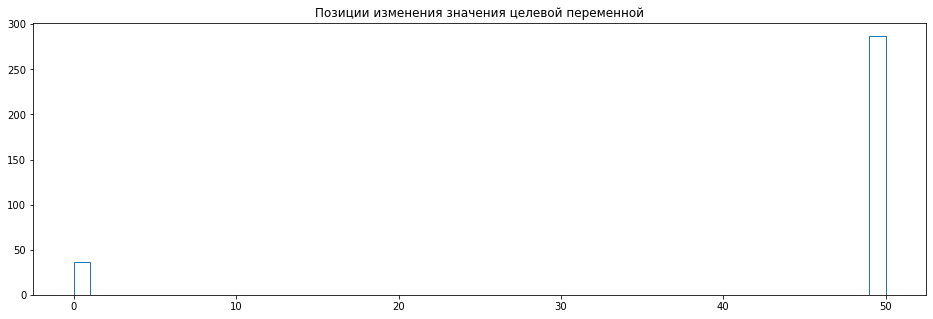

In [404]:
change_pos = np.apply_along_axis(find_change_poss, 1, target)
# change_pos.shape
plt.figure(figsize=(16,5))
plt.title('Позиции изменения значения целевой переменной')
plt.hist(change_pos, bins=50, histtype='step')
plt.show();

У части меток изменения жеста на происходит. Это соответствует команде '0-0', у остальных изменение происходит на 49 отсчете. Вероятно это искуственно сформированный момент.

А что с исходными данными?


### Сигналы с сенсоров

Посмотрим на график исходных данных.  В прошлой задаче положительное влияние на сокращение размерности исходных данных сыграло удаление сигналов с уровнем '<200'.  Пробую посмотреть на данные после удаления низкоуровневых сигналов.

In [405]:
# Формирую список сенсоров, сигнал на которых всегда меньше порога
min_sens_value = 200
sens2delete = np.flatnonzero(np.apply_over_axes(np.max, data, [0,2]).flatten() < min_sens_value) 
print(sens2delete.shape)
# удаляю данные по этим сенсорам из первоначального массива.
data = np.delete(data, sens2delete, axis=1)
print(data.shape)

(24,)
(323, 16, 100)


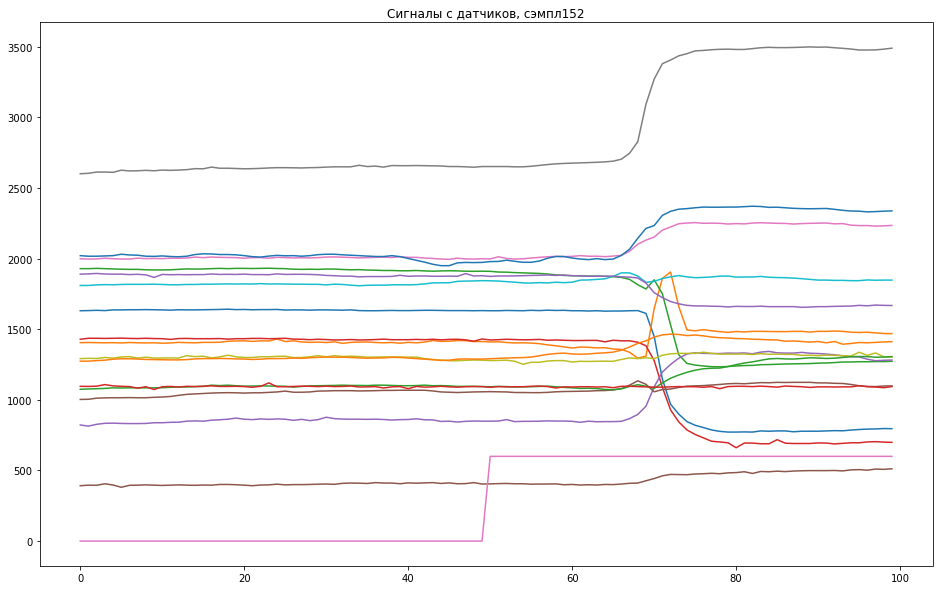

In [406]:
g = 152 # 16 # 30 # 126 #198  # 30
gr_x = np.arange(100)
plt.figure(figsize=(16,10))
plt.title('Сигналы с датчиков, cэмпл' +  str(g))
for i in range(data.shape[1]): 
    plt.plot(gr_x,data[g,i,:])
plt.plot(gr_x,target[g,:]*300)
plt.show();



*Прим: На этом графике я решил добавить значение целевой переменной на исходный большой график. Для этого оно масштабируется с коэффициентом 300.*

Не все наблюдения за исходным сигналом хорошие. Есть ряд наблюдений, для которых характерен тремор оптической плотности сигналов с датчиков. Количество таких наблюдений зависит от порогов фильтрации первой производной.  Ряд наблюдений состоят из классов 0-0, в них не выполняется никакого жеста, но происходит поворот ладони (направлена вниз, направлена перпендикулярно полу, направлена вверх). Поэтому датчики фиксируют некоторую активность.

Выявлены не очень хорошие наблюдения в ходе последующего исследования. Критерий качества - наличие некоторого количества небольших изменений плотности, не являющимися основным сигналом. 
 
Дифференцирую сигнал с одновременной фильтрацией по уровню снизу.  Возникла идея посмотреть еще на огибающую производной.  Пусть термин огибающая обозначает сумму модулей значений отфильтрованных производных. 

In [407]:
# Дифференцирование и фильтрация исходных данные
# thr - уровень фильтрации шума 
def diff_and_filter(data, thr):
    ddata = np.diff(data)
    return np.where(np.abs(ddata)<thr,0,ddata)

In [408]:
limiter_level = 20  # порог фильтрации слабых движений
# производные всех сигналов
diff_data = np.apply_along_axis(diff_and_filter, 2, data, limiter_level)
# diff_data.shape
# огибающая = сумма модулей производных
envelope_diff = np.apply_along_axis((lambda x: (np.abs(x)).sum()), 1, diff_data )
# envelope_diff.shape

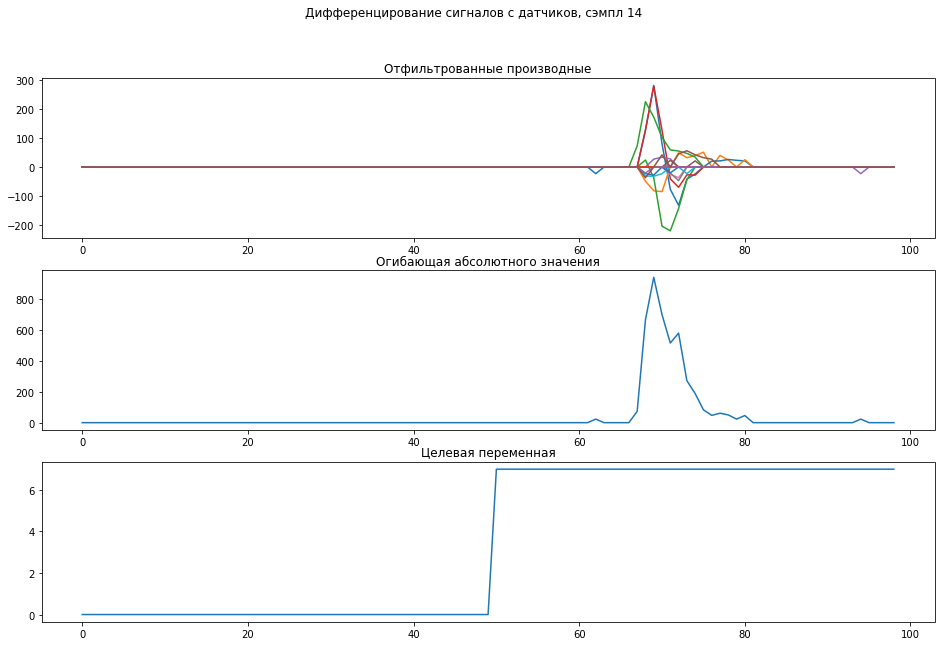

In [409]:
g = 14
fig, axs = plt.subplots(3, figsize=(16,10))
fig.suptitle('Дифференцирование сигналов с датчиков, cэмпл ' +  str(g))

axs[0].set_title('Отфильтрованные производные')
for i in range(data.shape[1]): 
    axs[0].plot(gr_x[:99],diff_data[g,i,:], label=str(i))
# axs[0].legend()

# plt.subplots(figsize=(16,3))
axs[1].set_title('Огибающая абсолютного значения')
axs[1].plot(gr_x[:99],envelope_diff[g,:99])

axs[2].set_title('Целевая переменная')
axs[2].plot(gr_x[:99],target[g,:99])

plt.show();

Глобальный максимум - момент совершения движения - можно находить как максимум огибающей.  Но не понятно как находить границы импульса максимальной амлитуды.  

Пробую отталкиваться от глобального максимума в наблюдении и от него находить ближайшие нулевые значения огибающей слева и справа.  Так находятся начало и окончание движения. 

In [410]:
# нахождение первого ненулевого отсчета, относящегося к глобальному максимуму 
# огибающей производной, позиции глобально макс и последнего ненулевого отсчета
def find_appearance_decay(diff):
    size = diff.shape[0]
    max_pos = np.argmax(diff)
    if max_pos == 0 : return 0, 0, 0
    for i in range(max_pos):
        loc = max_pos-i
        if diff[loc] == 0 : break
    app = loc+1
    for i in range(max_pos+1,size):
        if diff[i] == 0: break
    return app, max_pos, i-1
#   возвращает начало, макс и окончание движения

In [411]:
def make_sample_info1(data,target,limiter,span):
    num_samples = data.shape[0]
    res = np.zeros((num_samples,6))
    diff = np.apply_along_axis(diff_and_filter, 2, data, limiter)
    envelope = np.apply_along_axis((lambda x: (np.abs(x)).sum()), 1, diff )
    for s in range(num_samples):
        res[s,0] = target[s,0] + target[s,-1]
        res[s,1] = target[s,0]
        res[s,2] = target[s,-1]
        a, m, d = find_appearance_decay(envelope[s,:])
        # print(a,m,d)
        if (d-a)>= span: 
            res[s,3] = a ; res[s,4] = m; res[s,5] = d
        else:
            res[s,3] = 0 ; res[s,4] = 0; res[s,5] = 0 
    return res


Для удобства анализа делаю сводную информацию. Это массив с 6 строками. 
- Строка 0 - было ли движение по разметке
- Строка 1 - начальное положение
- Строка 2 - конечное положение
- Строка 3 - начало основного движения
- Строка 4 - максимум (глобальный) огибающей 
- Строка 5 - конец основного движения

Для фильтрации тонких узких иголок ввел переменную минимальная дистанция.  Пока она равна 2

In [412]:
limiter_level = 20.  # уровень ограничения производной по амплитуде снизу
span_distance = 4    # минимальная ширина пика
data_info = make_sample_info1(data,target,limiter_level, span_distance)
data_info.shape

(323, 6)

Проверка исходного массива на наличие ложно-определенных движений. 
Ложноположительное - найден максимум движения, хотя по разметке движения не было. 
Ложноотрицательные - не найдено максимума движения, хотя по разметке движение было. 

In [413]:
no_mvmnt = list(np.flatnonzero( (data_info[:,0]==0))) #наблюдения без движения
print('Наблюдения без движения по разметке', no_mvmnt, ', всего', len(no_mvmnt))

has_max = list(np.flatnonzero( (data_info[:,4]>0)))
print('Наблюдения с движением', has_max, ', всего', len(has_max))

wrong_mvmnt = list(np.flatnonzero((data_info[:,0]==0) & (data_info[:,4]>0) ))
print('Ложноположительные наблюдения', wrong_mvmnt, 'всего', len(wrong_mvmnt) )

wrong_still = list(np.flatnonzero(((data_info[:,0]>0) & (data_info[:,4]==0) )))
print('Ложноотрицательные наблюдения', wrong_still, 'всего', len(wrong_still) )



Наблюдения без движения по разметке [0, 1, 18, 19, 36, 37, 54, 55, 72, 73, 90, 91, 108, 109, 126, 127, 144, 145, 162, 163, 180, 181, 198, 199, 216, 217, 234, 235, 252, 253, 270, 271, 288, 289, 306, 307] , всего 36
Наблюдения с движением [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 1

Были подобраны параметры: 
- уровень обнуления значения производной = 20. 
- минимальная ширина настоящего движения = 4. 

В результате подбора этих параметров удалось обеспечить нулевой уровень ложноотрицательных сигналов (по разметке движение есть а дифференциатор его не видит).  Ложноположительных движений (по разметке движения нет, но оптическая плотность существенно меняется) довольно много - 20. 

Еще одна идея исследования сигналов с сенсоров - посмотреть на изменение СКО от сенсора к сенсору.  Может быть там есть малоизменчивые и их тоже надо убирать? 

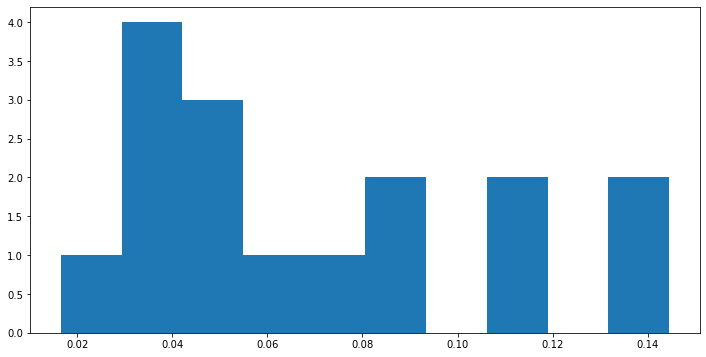

In [414]:
max_value = data.max()
sensor_var = np.std(data.swapaxes(0,1).reshape((data.shape[1],-1)),1)/max_value
plt.figure(figsize=(12,6))
plt.hist(sensor_var,bins=10)
plt.show();

In [415]:
print('СКО различных каналов:', sorted(sensor_var))

СКО различных каналов: [0.01648701744350335, 0.035617754916817956, 0.0367103749102668, 0.0374538109117722, 0.03754216076030951, 0.04474943326732222, 0.05011027379749497, 0.05078928484060997, 0.0668356983657064, 0.08046537127625628, 0.08069127986903726, 0.08834207785331284, 0.11810621972309945, 0.11852525712718903, 0.13424460340660133, 0.14457962010702455]


Есть идея попробовать отборосить еще и канал с наименьшим СКО. 

In [416]:
small_sens_variation = 0.02
# Нахожу и удаляю сенсоры с малым СКО
small_var_sens = np.flatnonzero(sensor_var < small_sens_variation)
print('Sensor channels with small variations',small_var_sens)
if len(small_var_sens) > 0:
  data = np.delete(data, small_var_sens, axis = 1 )
  #X_test_n = np.delete(X_test_n, small_var_sens, axis=1)
print('X train:', data.shape) #; print('X_test:', X_test_n.shape)  

Sensor channels with small variations [13]
X train: (323, 15, 100)


### Уточнение разметки


У товарища по команде согласно рекомендации организатора возникла идея изменить целевую переменную. Подготовлю данные для передачи.   

In [417]:
# Расчет откорректированного значения целевой переменной
# target - исходная переменная
# pos - отсчет, в который должно измениться значение
def change_target(target, pos):
    size = target.shape[0]
    new = np.zeros(size)
    for i in range(size):
        new[i] = target[0] if i < pos else target[-1]
    return new


Новый таргет будет переходить из одного состояния в другое в момент глобального максимума огибающей.

In [468]:
new_target = np.zeros_like(target)
num_obs = target.shape[0]
for i in range(num_obs):
    new_target[i,:] = change_target( target[i,:], data_info[i,4]-2) #max-1 - лучшая позиция

Как выглядит уточненный таргет на фоне других признаков и старой целевой переменной?

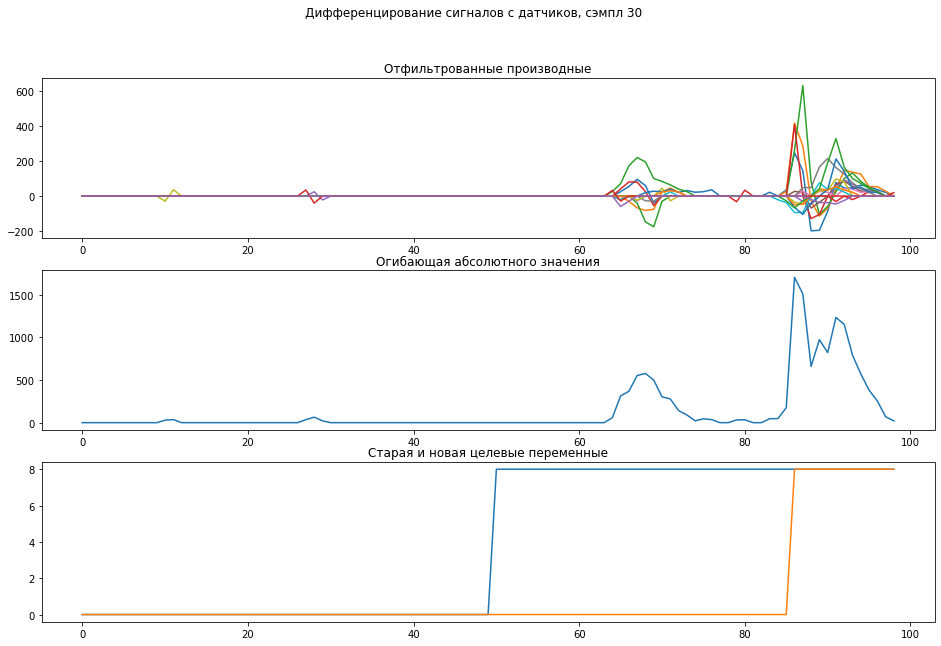

In [419]:
g = 30  # номер наблюдения
fig, axs = plt.subplots(3, figsize=(16,10))
fig.suptitle('Дифференцирование сигналов с датчиков, cэмпл ' +  str(g))
for i in range(data.shape[1]): 
    axs[0].plot(gr_x[:99],diff_data[g,i,:], label=str(i))
# axs[0].legend()
axs[0].set_title('Отфильтрованные производные')

# plt.subplots(figsize=(16,3))
axs[1].set_title('Огибающая абсолютного значения')
axs[1].plot(gr_x[:99],envelope_diff[g,:99])

axs[2].set_title('Старая и новая целевые переменные')
axs[2].plot(gr_x[:99],target[g,:99])
axs[2].plot(gr_x[:99],new_target[g,:99])

plt.show();

Сохраняю новый массив целевых переменных для обучения НС.

In [420]:
np.save('left_targ.npy', new_target)# 

Исходная картинка для презентации Стратегий распознавания.

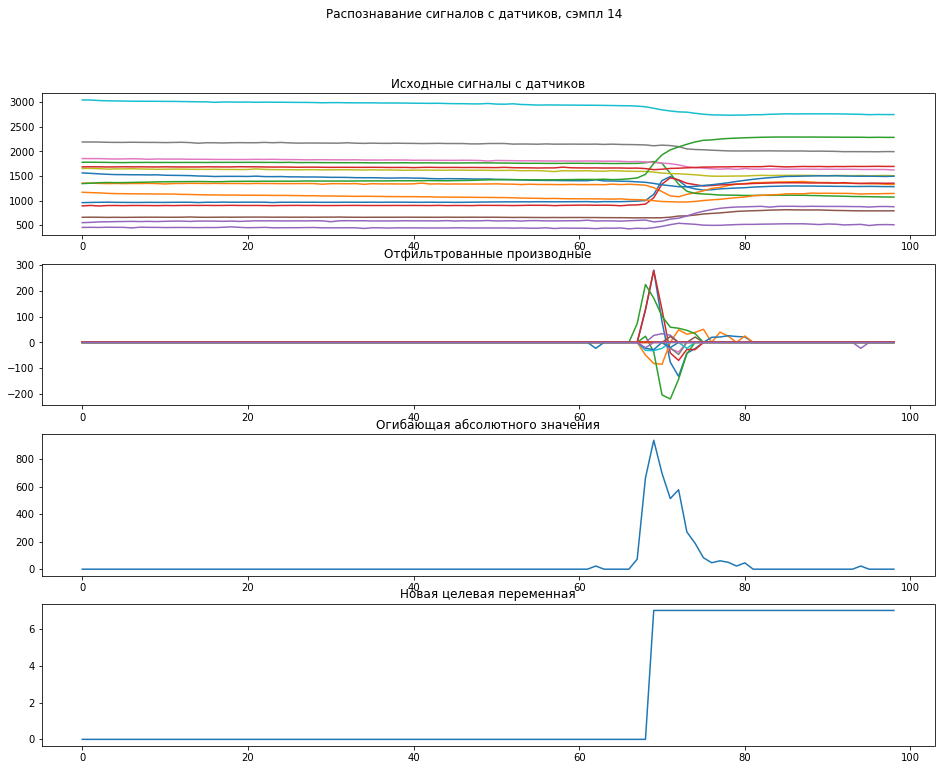

In [421]:
g = 14  # номер наблюдения
fig, axs = plt.subplots(4, figsize=(16,12))
fig.suptitle('Распознавание сигналов с датчиков, cэмпл ' +  str(g))

for i in range(data.shape[1]): 
    axs[0].plot(gr_x[:99],data[g,i,:99], label=str(i))
# axs[0].legend()
axs[0].set_title('Исходные сигналы с датчиков')

for i in range(data.shape[1]): 
    axs[1].plot(gr_x[:99],diff_data[g,i,:], label=str(i))
# axs[1].legend()
axs[1].set_title('Отфильтрованные производные')

# plt.subplots(figsize=(16,3))
axs[2].set_title('Огибающая абсолютного значения')
axs[2].plot(gr_x[:99],envelope_diff[g,:99])

axs[3].set_title('Новая целевая переменная')
#axs[3].plot(gr_x[:99],target[g,:99])
axs[3].plot(gr_x[:99],new_target[g,:99])

plt.show();

### Исследование характеристик переходного процесса

Как распределились характеристики начала и конца переходного процесса по наблюдениям? 

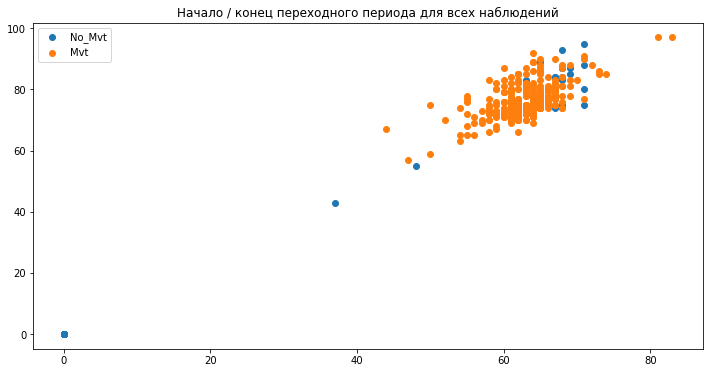

In [422]:
no_mvt_info = data_info[data_info[:,0] == 0]
mvt_info = data_info[data_info[:,0] > 0]


plt.figure(figsize=(12, 6))
plt.title('Начало / конец переходного периода для всех наблюдений')
plt.scatter(no_mvt_info[:, 3], no_mvt_info[:,5], label = 'No_Mvt')
plt.scatter(mvt_info[:, 3], mvt_info[:,5], label = 'Mvt')
plt.legend()
#    plt.xlim([0,1])  # 
plt.show()

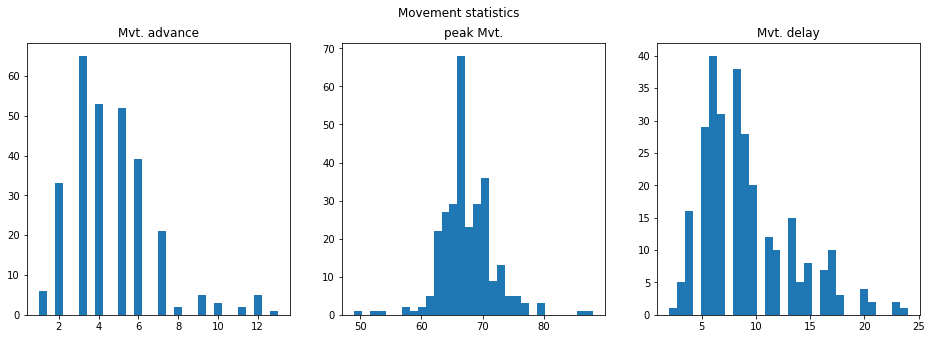

Advance Quantiles: [3. 4. 6. 7.]
Peak Quantiles: [65. 67. 70. 73.]
Delay Quantiles: [ 6.   8.  11.  15.4]


In [423]:
mvt_adv = mvt_info[:,4] - mvt_info[:,3]
mvt_del = mvt_info[:,5] - mvt_info[:,4]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,5))
fig.suptitle('Movement statistics')
ax1.set_title('Mvt. advance')
ax1.hist(mvt_adv,bins=30)
ax2.set_title('peak Mvt.')
ax2.hist(mvt_info[:,4],bins=30)
ax3.set_title('Mvt. delay')
ax3.hist(mvt_del,bins=30)
plt.show();
print('Advance Quantiles:', np.quantile(mvt_adv,q=[0.25,0.5,0.75,0.90]))
print('Peak Quantiles:', np.quantile(mvt_info[:,4],q=[0.25,0.5,0.75, 0.90]))
print('Delay Quantiles:', np.quantile(mvt_del,q=[0.25,0.5,0.75,0.90]))

С вероятностью 90% Можно считать, что движение начинается за 7 отсчетов относительно пика и заканчивается через 15 отсчетов.  Но есть не очень хорошие наблюдения, где движение происходит почти в самом конце.

In [424]:
far_right_samples=list(np.flatnonzero(data_info[:,4]>80))
for i in far_right_samples:
    print('Sample:',i,data_info[i]) 

Sample: 16 [ 4.  0.  4. 81. 88. 97.]
Sample: 30 [ 8.  0.  8. 83. 86. 97.]
Sample: 108 [ 0.  0.  0. 71. 82. 95.]


Для таких отсчетов надо сделать особые условия формирования уровня сигнала после завершения. 

А как выглядит гистограмма уровня пика огибающей?

In [425]:
num_samples = data_info.shape[0]
max_env = np.zeros(num_samples)
for s in range(num_samples):
    max_env[s] = envelope_diff[s, int(data_info[s,4])]


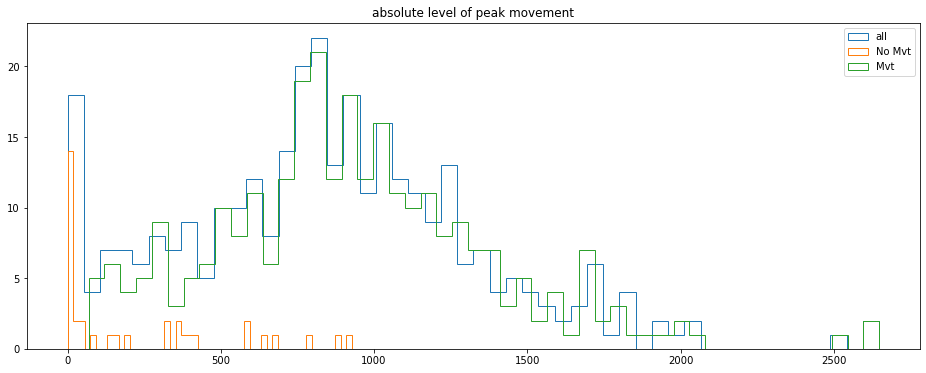

In [426]:
plt.figure(figsize=(16,6))
plt.title('absolute level of peak movement')
plt.hist(max_env, bins=50, label='all', histtype='step')
plt.hist(max_env[data_info[:,0]==0], bins=50, label='No Mvt', histtype='step')
plt.hist(max_env[data_info[:,0]>0], bins=50, label='Mvt', histtype='step')
plt.legend()
plt.show()
# print('Level Quantiles:', np.quantile(env_max_lvl,q=[0.05,0.25,0.5,0.75,0.95]))

Размеченные движения могут иметь небольшой пик.  На гистограмме видно, что наблюдения с отсутствием размеченного движения могут иметь довольно большие пики. По уровню сиигнала разделить не удастся. 

Как могут выглядеть стратегии обучения? 

### Возможные стратегии решения задачи распознавания с помощью ML

![Strategy](Pics/RecognitionStrategy.jpg)

Можно выделить две стратегии обучения, если не прибегать к глубокому обучению НС:
- "Уровни" - подход с распознаванием уровней сигнала в различных состояниях
- "Фронт" - подход с распознаванием непосредственно переходного процесса. 

**Подход "Уровни"**

На каждом тайм-фрейме необходимо выделить зону переходного процесса из одного состояния в другое. Соответственно каждый тайм-фрейм будет представлять из себя последовательность (состояние 1, переходный процесс, состояние 2).  Для задачи МашОба мы вырезаем куски состояния 1 и состояния 2, считаем по ним средние значения каждого уровня и формируем модель  уровни сигналов - предсказание состояния кисти (какие пальцы сжаты).  Обучаем модель на этих табличках значений.  

Работа со скор-набором - также разбираем каждый тайм-фрейм набора на два состояния и определяем по обученной модели состояния сжатия пальцев.  Распознанные состояния пакуем в ответ и загружаем в систему. 

**Поход Фронт** 

В каждом таймфрейме выделяется зона переходного процесса и она кодируется аналогично тому, как это решалось в прошлой задаче. 

Каждый из этих вариантов предусматривает решение задачи традиционного машинного обучения (Classic ML = CML). Подход к решению задачи глубокого обучения попробую после. 

## 2. Решение традиционной ML задачи 

### Разработка признаков традиционной модели на основе подхода "Уровни"

In [427]:
min_sens_value = 200
limiter_level = 20.  # уровень ограничения производной по амплитуде снизу
span_distance = 4    # минимальная ширина пика

In [428]:
data = np.load('data/X_train.npy')
print('Original Data Shape:', data.shape)
target = pd.read_csv('data/y_train.csv', index_col=0)
target = target['class'].values
print('Original Target Shape:', target.shape) 
target = target.reshape((323,100))
print('New Target Shape:', target.shape) 

# нахожу сенсоры под удаление
sens2delete = np.flatnonzero(np.apply_over_axes(np.max, data, [0,2]).flatten() < min_sens_value) 
print('Sensors to delete',sens2delete.shape[0])
# удаляю данные по этим сенсорам из первоначального массива.
data = np.delete(data, sens2delete, axis=1)
print('Working Data Shape',data.shape)

Original Data Shape: (323, 40, 100)
Original Target Shape: (32300,)
New Target Shape: (323, 100)
Sensors to delete 24
Working Data Shape (323, 16, 100)


In [429]:
small_sens_variation = 0.02
# Нахожу и удаляю сенсоры с малым СКО
if small_sens_variation > 0 :   #выключатель удаления малых СКО
  max_value = data.max()
  sensor_var = np.std(data.swapaxes(0,1).reshape((data.shape[1],-1)),1)/max_value
  small_var_sens = np.flatnonzero(sensor_var < small_sens_variation)
  print('Sensor channels with small variations',small_var_sens)
  if len(small_var_sens) > 0:
    data = np.delete(data, small_var_sens, axis = 1 )
    #X_test_n = np.delete(X_test_n, small_var_sens, axis=1)
  print('X train:', data.shape) #; print('X_test:', X_test_n.shape)  

Sensor channels with small variations [13]
X train: (323, 15, 100)


In [430]:
#   Выделение границ переходного процесса в виде массива значений
def Slicer(data,limiter,span):
    num_samples = data.shape[0]
    markers = np.zeros((num_samples,3))
    diff = np.apply_along_axis(diff_and_filter, 2, data, limiter)
    envelope = np.apply_along_axis((lambda x: (np.abs(x)).sum()), 1, diff )
    # Рассчитываю маркеры 
    # Маркеры - либо отсчеты перед и после переходного процесса, 
    # либо две точки посередине
    for s in range(num_samples):
        a, m, d = find_appearance_decay(envelope[s,:])
        # print(a,m,d)
        if (d-a)>= span: 
            markers[s,0] = int(a) ; markers[s,1] = int(m); markers[s,2] = int(d+1)
        else:
            markers[s,0] = 49 ; markers[s,1] = 49 ; markers[s,2] = 50 
    return markers
# markers - массив из трех строк, 
# строка 0 конец временной зоны до переходного процесса
# строка 1 момент движения
# строка 2 начало временной зоны после завершения переходного процесса

Выделяю границы переходного процесса в трейн.

In [431]:
slice_info = Slicer(data,limiter_level, span_distance)
slice_info.shape

(323, 3)

In [432]:
#  Нарезка исходных данных на сегменты по границам установившихся уровней и
#  рассчет среднего значения каждого сенсора внутри уровня
def TrainParcer_toSlices(data,target,limiter,span):
    num_sensors = data.shape[1]
    num_samples = data.shape[0]
    num_meas = data.shape[2]
    slice_info = Slicer(data,limiter,span)
    output_exists = False
    # new_slice = np.zeros((num_sensors))
    # Нарезаю на куски и рассчитываю среднее по каждому куску по каждому сенсору
    # запонимю информаци о среднем по сенсору
    #
    for smpl in range(num_samples): 
        adv_marker = int( slice_info[smpl,0] if slice_info[smpl,0] > 5 else slice_info[smpl,0]+5 )
        dec_marker = int( slice_info[smpl,2] if slice_info[smpl,2] < num_meas-6 else slice_info[smpl,2] -5 )
        # print(adv_marker, dec_marker)
        #left_slice = data[smpl,:,0:adv_marker]
        left_levels = np.apply_along_axis(np.mean,1, data[smpl,:,0:adv_marker]).reshape((1,num_sensors))
        # print(left_slice.shape)
        # print(left_slice)
        # print(left_levels.shape)
        # print(left_levels)
        #right_slice = data[smpl,:,dec_marker:num_meas]
        right_levels = np.apply_along_axis(np.mean,1,data[smpl,:,dec_marker:num_meas]).reshape((1,num_sensors))
        # print(right_levels.shape)
        # print(right_levels)
        two_levels = np.concatenate((left_levels,right_levels),axis=0)
        two_labels = np.array([[target[smpl,0]], [target[smpl,-1]] ])
        two_loc = np.array([ [smpl], [smpl] ])
        if output_exists :
            levels = np.concatenate((levels, two_levels), axis=0)
            labels = np.concatenate((labels, two_labels), axis=0)
            locations = np.concatenate((locations, two_loc), axis=0)
        else: 
            levels = two_levels; labels = two_labels; locations = two_loc; 
            output_exists = True
    return levels, labels.ravel(), locations.ravel()
    # levels - средние значения по каждому датчику в течение выделенного временного отрезка
    # labels - метки отношения к классу = команде
    # locations - положение того или иного куска в исходных данных
    

Нарезаю трейн на кусочки и рассчитываю уровни в кусочках.

In [433]:
level_slices, level_labels, level_locations = TrainParcer_toSlices(data,target,limiter_level,span_distance)
print(level_slices.shape, level_labels.shape, level_locations.shape)


(646, 15) (646,) (646,)


Нормализация и создание полиномиальных признаков.

In [434]:
# нормализую по уровню максимального наблюдения
global_max = level_slices.max()
norm_level_slices = level_slices / global_max
# делаю полиномиальные комбинации признаков
poly = PolynomialFeatures(2, include_bias=False)
norm_level_slices = poly.fit_transform(norm_level_slices)
print('Shape with polinomial features:',norm_level_slices.shape)


Shape with polinomial features: (646, 135)


In [435]:
X_train, X_test, y_train, y_test = train_test_split(norm_level_slices, level_labels, test_size = 0.2)
print('Test:', X_test.shape)
LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=10, random_state=42, max_iter=5000)
LR_clf.fit(X_train, y_train)

#y_pred = clf.predict(X_test_review_tfidf)
y_pred = LR_clf.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, y_pred))

Test: (130, 135)
Test Accuracy:  0.9230769230769231


Добавление полиномиальных признаков улучшило точность.



### Выбор модели и подбор гиперпараметров

Проверяю точность и выбираю модель.  Возникло предположение, что случайный лес справится с задачей лучше логистической регрессии. На валидации так и было. Однако на тесте на каггл логистическая регрессия показала лучший результат. Поэтому параметры подбирал для нее. 

In [436]:
# Функция для проверки классификатора методом кросс-валидации 
def validate_classifier(X,y,cls):
    skf = StratifiedKFold(n_splits=5)
    metr=0
    for train_index,  val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        cls.fit(X_train,y_train)
        metr += accuracy_score(y_val,cls.predict(X_val))
    return metr/5.

In [437]:
LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=10, random_state=42, max_iter=5000, n_jobs=-1)
RF_clf = RandomForestClassifier(n_estimators=2000, n_jobs=-1, random_state=42)

In [438]:
print('RocAuc Score with LogisticRegressionClassifier:', validate_classifier(norm_level_slices,level_labels,LR_clf))
print('RocAuc Score with RandomForestClassifier:', validate_classifier(norm_level_slices,level_labels,RF_clf))


RocAuc Score with LogisticRegressionClassifier: 0.9505903398926655
RocAuc Score with RandomForestClassifier: 0.9459153249850925


При первом подходе получились результаты:
- LR 0.9165
- RF 0.9444

Случайный Лес показывает чуть лучший результат. 

При добавлении полиномиальных признаков результаты улучшились:
- LR 0.95677
- RF 0.95210 -> 0.95827

При добавлении полиномиальных признаков Логистическая Регрессия снова стала лучше. Однако увеличение количества эстиматоров до 2000 Случайный лес снова впереди. 

Но на kaggle Логистическая Регрессия все же лучше. 
Попробую подобрать параметры Логистической Регрессии.

In [439]:
# подбор solver
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
for s in solver: 
    LR_clf = LogisticRegression(multi_class='multinomial', solver=s, penalty='l2', C=10, random_state=42, max_iter=5000, n_jobs=-1)
    print('solver:',s,validate_classifier(norm_level_slices,level_labels,LR_clf))

solver: newton-cg 0.9505903398926655
solver: lbfgs 0.9505903398926655
solver: sag 0.9505903398926655
solver: saga 0.9505903398926655


In [440]:
# Подбор коэффициента C
#
c_list = [100,200,300,400,500,600] #[100,200,300,400,500,600,700,800,900,1000]  #1,10,100,1000,2000
for s in c_list: 
    LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=s, random_state=42, max_iter=5000, n_jobs=-1)
    print('C:',s,validate_classifier(norm_level_slices,level_labels,LR_clf))

C: 100 0.979964221824687
C: 200 0.9845915324985093
C: 300 0.9830411449016101
C: 400 0.9845915324985093
C: 500 0.9845915324985093
C: 600 0.9845915324985093


Наилучший вариант при C=200..500. Пусть будет 250

In [441]:
LR_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=250, random_state=42, max_iter=5000, n_jobs=-1)

clf = LR_clf

### Интерпретация и подстройка модели

In [442]:
# разбор и сравнение оригинала и предсказания, 
# возвращает массив, в каждой строке - наблюдение, правильная и неправильная классификация
def compare_labels(original, predict, location):
    num_labels = original.shape[0]
    err_list = list()
    for l in range(num_labels):
        if original[l] != predict[l]:
            err_list.append([location[l], original[l], predict[l]])
    return err_list

In [443]:
# Функция для проверки классификатора 
def get_validation_err(X,y,loc,cls):
    skf = StratifiedKFold(n_splits=5)
    metr=0
    err = list()
    err_list_empty = True
    for train_index,  val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        _, loc_val = loc[train_index], loc[val_index]
        cls.fit(X_train,y_train)
        y_pred = cls.predict(X_val)
        metr += accuracy_score(y_val,y_pred)
        if err_list_empty:
            err = compare_labels(y_val, y_pred, loc_val)
            err_list_empty = False
        else:
            err.extend( compare_labels(y_val, y_pred, loc_val))
    return metr/5., err

Возникла идея посмотреть на ошибки и улучшить качество распознавания за счет дополнительного правила проверки.

In [444]:
acc, errors = get_validation_err(norm_level_slices, level_labels, level_locations, clf)
print('Accuracy', acc)
print('Всего ошибок',len(errors))
# список не хешируется, поэтому преобразовываю в список строк, затем устраняю дубликаты
# разбираю и сортирую
char_err = ['_'.join(str(y) for y in x) for x in errors]
uni_char_err = list(set(char_err))
uni_err = sorted([ [ int(x) for x in l.split('_') ] for l in uni_char_err])
print('Уникальных ошибок', len(uni_err))

Accuracy 0.9830411449016101
Всего ошибок 11
Уникальных ошибок 9


При использовании алгоритма случайный лес при кросс-валидации обучающего набора выявлено 26 ошибок, в том числе одна повторялась два раза. 
При использовании алгоритма логистической регрессии было всего 6 ошибок, и одна (или две) повторялись два раза.  Качество по количеству ошибок явно выше у Логистической регрессии. 

In [445]:
err_cnt=dict()
err_loc=dict()
for e in uni_err:
    err_marker = str(e[1])+'->'+str(e[2])
    cnt = err_cnt.get(err_marker,0)
    err_cnt[err_marker] = cnt+1
    li = [] if cnt ==0 else err_loc[err_marker]
    li.append(e[0])
    err_loc[err_marker] = li

for k in err_cnt.keys():
    print('Err',k, err_cnt[k], 'times at samlpe(s)', err_loc[k] )
        
#print(err_cnt)
#print(err_loc)

Err 0->6 4 times at samlpe(s) [0, 1, 2, 12]
Err 5->7 2 times at samlpe(s) [4, 5]
Err 2->1 1 times at samlpe(s) [134]
Err 6->1 1 times at samlpe(s) [165]
Err 7->5 1 times at samlpe(s) [248]


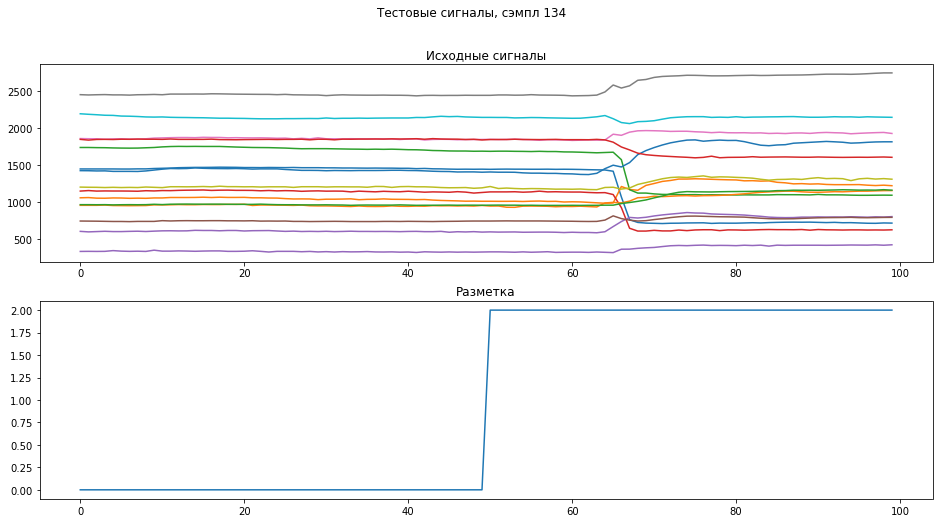

In [446]:
g = 134
gr_x = np.arange(data.shape[2])
fig, axs = plt.subplots(2, figsize=(16,8))
fig.suptitle('Тестовые сигналы, cэмпл ' +  str(g))

axs[0].set_title('Исходные сигналы')
for i in range(data.shape[1]): 
    axs[0].plot(gr_x,data[g,i,:], label=str(i))

axs[1].set_title('Разметка')
axs[1].plot(gr_x,target[g,:])

plt.show();

Для анализа важности коэффициентов регрессии можно использовать два подхода: 
- подход на основе экспоненты в степени коэфффициентов (https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/)
- подход на основе перемножения (или деления) величины коэффициентв на СКО сигнала соответствующего признака (https://stackoverflow.com/questions/34052115/how-to-find-the-importance-of-the-features-for-a-logistic-regression-model)

Мне больше понравился второй подход, так как дисперсия в каналах разная и я не делал нормализации на дисперсию, только привел все сигналы к одному уровню.  Этот подход реализован ниже.  На графиках по оси Х отложен номер коэффициента, по оси Y - номер команды. 

Всего в модели 152 коэффициента. Из них 16 - первоначальные и 136 - полиномиальные признаки.  Поэтому я построил два графика - все признаки и первичные признаки.  

Количество в отображении можно менять. Для примера, взяты 10 самых важных коэффициентов.  Можно также посмотреть на 20% (152*20% = 39) самых важных коэффициентов. 

In [447]:
num_coef = 10  # сколько коэффициентов отобразить
model_coef = clf.coef_
# print(model_coef.shape)
train_std = np.std(norm_level_slices,0)
coef_importance = np.abs( model_coef * train_std)
# coef_importance.shape

num_cmd = model_coef.shape[0]
imp_coef = np.zeros((num_cmd,num_coef))
# cmd = 0   # номер команды
qnt_hurd = 1. - num_coef / train_std.shape[0]
for cmd in range(num_cmd):
    class_coef_imp = coef_importance[cmd]
    hurdle = np.quantile(class_coef_imp,q=[qnt_hurd])[0]
    imp_coef[cmd] = np.flatnonzero(class_coef_imp >= hurdle)


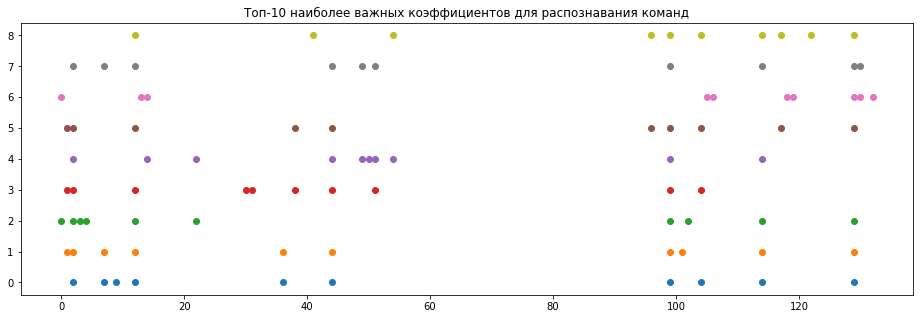

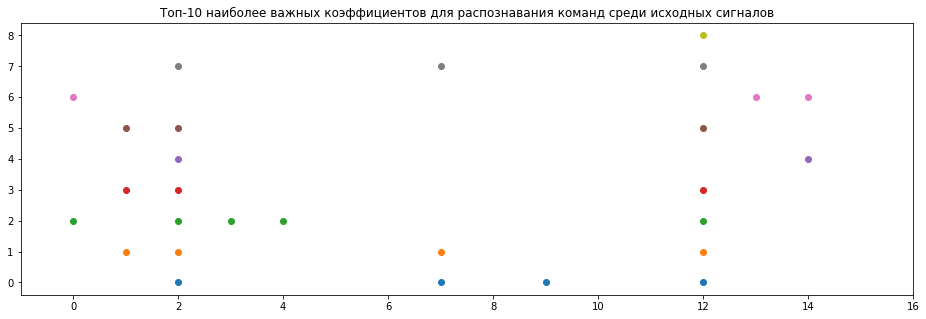

In [448]:
plt.figure(figsize=(16, 5))
plt.title('Топ-'+str(num_coef)+' наиболее важных коэффициентов для распознавания команд')
for cmd in range(num_cmd):
    plt.scatter(imp_coef[cmd,:], np.full((num_coef) ,cmd), label = str(cmd))
# plt.legend()
#    plt.xlim([0,1])  # 
plt.show()
plt.figure(figsize=(16, 5))
plt.title('Топ-'+str(num_coef)+' наиболее важных коэффициентов для распознавания команд среди исходных сигналов')
for cmd in range(num_cmd):
    plt.scatter(imp_coef[cmd,:], np.full((num_coef) ,cmd), label = str(cmd))
# plt.legend()
plt.xlim([-1,16])  # Первые 16 каналов важны
plt.show()

 Среди исходных признаков с наибольшей важностью чаще всего встречаются канал 2 и 12.  Если бы вместо массива Numpy на этапе формирования признаков использовать Датафрейм от Панды, то вероятно можно было бы посмотреь происхождение полиномиальных коэффициентов. 

### Формирование предсказания - результата

In [465]:
#  Функция преобразования двух меток классов в скачок с переходом 
#  по центру движения (allign2max = true) или по началу движения

def merge_slice_labels_together(slice_labels, slice_info, duration, allign2max = True):
    num_samples = slice_info.shape[0]
    empty_res = True
    for s in range(num_samples):
        sl = s*2
        sr = s*2+1
        # 0 столбец - начало импульса
        # 1 столбец - пик первой производной = момент самого быстрого изменения
        pos1 = int(slice_info[s,1])-1 if allign2max else int(slice_info[s,0])
        left_slice = np.full((pos1), slice_labels[sl])
        right_slice = np.full((duration-pos1), slice_labels[sr] )
        slice = np.concatenate((left_slice,right_slice),axis=0).reshape((1,duration))
        if empty_res :
            res = slice; empty_res = False
        else:
            res = np.concatenate( (res,slice) ,axis=0)
    return res


Пробую сформировать предсказание

In [450]:
test_data = np.load('data/X_test.npy')
print('Original Test Shape:', test_data.shape)
test_data = np.delete(test_data, sens2delete, axis=1)
print('Working Data Shape',test_data.shape)
if small_sens_variation > 0 :   #выключатель удаления малых СКО
  if len(small_var_sens) > 0:
    test_data = np.delete(test_data, small_var_sens, axis = 1 )
  print('X test:', test_data.shape) 
# Нарезка на уровни-кусочки 
test_slice_info = Slicer(test_data,limiter_level, span_distance)
print('Test Slice Shape:',test_slice_info.shape)
test_target = np.zeros((test_data.shape[0], test_data.shape[2]))
print('Test Target Shape:', test_target.shape)
test_level_slices, _ , __ = TrainParcer_toSlices(test_data,test_target,limiter_level,span_distance)
print('Test Slices shape',test_level_slices.shape)

Original Test Shape: (54, 40, 100)
Working Data Shape (54, 16, 100)
X test: (54, 15, 100)
Test Slice Shape: (54, 3)
Test Target Shape: (54, 100)
Test Slices shape (108, 15)


In [451]:
# Нормализация по уровню!
test_level_slices = test_level_slices / global_max
# Добавление полиномиальных признаков
test_level_slices = poly.transform(test_level_slices)

In [452]:
clf = LR_clf  #RF_clf

clf.fit(norm_level_slices,level_labels)
test_level_predict = clf.predict(test_level_slices)
test_level_proba = clf.predict_proba(test_level_slices)

# RF_clf.fit(norm_level_slices,level_labels)
# test_level_predict = RF_clf.predict(test_level_slices)
print('Predict Shape:', test_level_predict.shape)
# test_level_predict

Predict Shape: (108,)


Общее описание алгоритма:
Трейн:
- формирую список сенсоров низкого уровня
- удаляю по списку
- выделяю начало, пик и конец переходного периода
- разделяю на зоны начального положения и конечного положения и определяю в них среднее значение уровня
- определяю макс уровень трейна нормирую все по макс уровню
- обучаю классификатор

Тест:
- удаляю по списку сенсоров низкого уровня
- выделяю начало, пик и конец переходного периода
- разделяю на зоны начального и конечного положения, считаю в них среднее значение
- нормирую все по макс уровню трейна
- на обученном классификаторе делаю предсказание
- сцепляю предсказания в форму организаторов
- отправляю на каггл


### Анализ результатов

Проба проверки предсказания. Проверяю правило о том, что в распознанных командах для каждого наблюдения хотя бы одна команда должна быть 0 (слева или справа).

In [453]:
predict_pairs = test_level_predict.reshape((-1,2))
positions = {1,2,3,4,5,6,7,8}
# positions
err_found=False
for s in range(predict_pairs.shape[0]):
    if (predict_pairs[s,0] in positions) and ( predict_pairs[s,1] in positions) : 
        print('Err:', s, predict_pairs[s,0], predict_pairs[s,1])
        err_found=True
        
print( 'Errors!' if err_found else 'No Errors' )

No Errors


Было желание в случае ошибок распознавания с двумя ненулевыми командами слева и справа сделать проверку вероятности и выбирать вариант с наибольшей вероятностью. 

In [466]:
len_observ = test_data.shape[2]
test_predict = merge_slice_labels_together(test_level_predict,test_slice_info,len_observ)
print('Test Predict Shape:', test_predict.shape)
# test_predict

test_level_proba=test_level_proba.reshape((-1,2,test_level_proba.shape[1]))
# test_level_proba.shape

Test Predict Shape: (54, 100)


Есть ли "проблемные" наблюдения, в которых какая-нибудь вероятность меньше 0.95? 

In [455]:
qus = []
for i in range(test_level_proba.shape[0]):
    if test_level_proba[i].max() < 0.95 :
        qus.append(i)
print('Questionable predictions:', qus if len(qus)>0 else 'No'  )

Questionable predictions: No


Как выглядят предсказания?

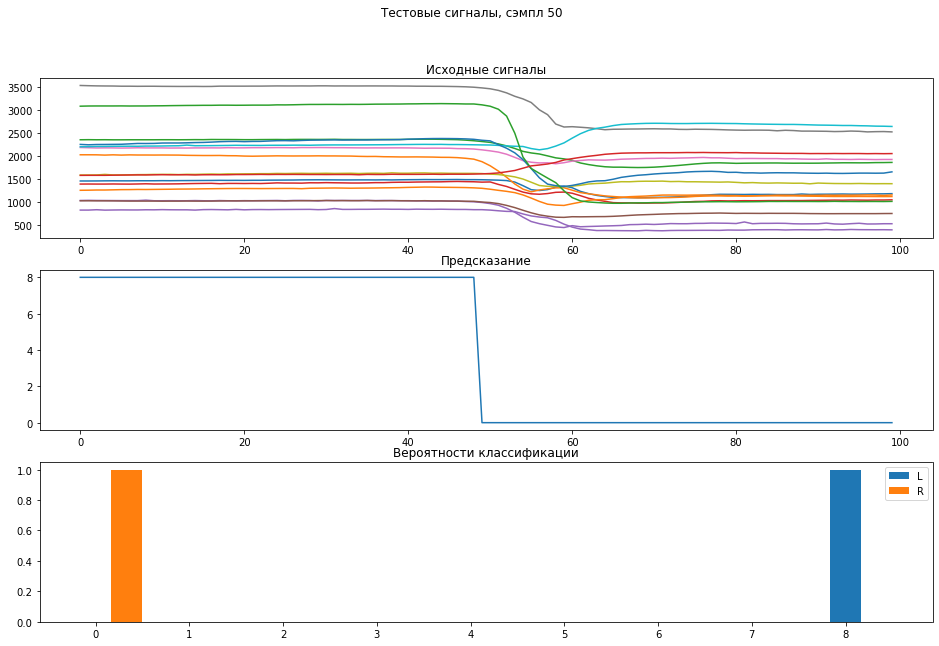

In [456]:
g = 50    # номер сэмпла тестового сигнала
gr_x = np.arange(test_data.shape[2])
x_L = np.arange(test_level_proba.shape[2])
bw = 0.33
x_R = [x + bw for x in x_L]

fig, axs = plt.subplots(3, figsize=(16,10))
fig.suptitle('Тестовые сигналы, cэмпл ' +  str(g))

axs[0].set_title('Исходные сигналы')
for i in range(test_data.shape[1]): 
    axs[0].plot(gr_x,test_data[g,i,:], label=str(i))

axs[1].set_title('Предсказание')
axs[1].plot(gr_x,test_predict[g,:])

axs[2].set_title('Вероятности классификации')
axs[2].bar(x_L,test_level_proba[g,0],width=bw, label='L')
axs[2].bar(x_R,test_level_proba[g,1],width=bw, label='R')
axs[2].set_xticks(x_L)
axs[2].legend()


plt.show();

### Формирование файла для Kaggle

In [467]:

# Генерирую индекс для теста
len_data = data.shape[0]
test_index = [ str(i)+'-' + str(j)  for i in range(len_data, len_data + test_predict.shape[0]) for j in range(test_predict.shape[1])  ]
test_out = pd.Series(data=test_predict.flatten(), index=test_index, name='class')
test_out.to_csv('./Submission/220923_04.csv',index_label='sample-timestep') #

Kaggle Submissions: 

- Submission 1 - Score: 0.96592
- Submission 2 - Score: 0.96481
- Submission 3 - Score: 0.97074
- Submission 4 - Score: 0.97555  - LogReg c C = 250
- Submission 5 - Score: 0.97555 - после удаления канала сенсора с малым СКО

Подбор положения: 
- позиция начало импульса +1 Score 0.96666
- позиция началао импульса  Score 0.96074
- позиция макс производной -1 Score 0.97962   (220923_03.csv)
- позиция макс производной -2 score 0.97740 